# Health Insurance Cross Sell Prediction using FEDOT and LLM

## Setup

In [1]:
import os
import sys
import re

import numpy as np
import pandas as pd

from pprint import pprint

module_path = os.path.abspath(os.path.join(os.sep.join(['..', '..'])))
if module_path not in sys.path:
    sys.path.append(module_path)

from fedot_llm.fedot_util import run_example
from fedot_llm.language_models.actions import ModelAction
from fedot_llm.language_models.llms import OllamaLLM
from fedot_llm.data.data import Dataset
from fedot_llm.language_models import prompts

## Data Loading and Exploration

In this section, we load the Health Insurance dataset.

In [2]:
dataset_name = 'health_insurance'
datasets_folder = os.sep.join([module_path, 'datasets'])
dataset_path = os.sep.join([datasets_folder, dataset_name])
dataset = Dataset.load_from_path(dataset_path)

In [3]:
import json
description_file = 'big_descriptions.json'
with open(os.sep.join([datasets_folder, description_file]), 'r') as json_file:
    dataset_big_descriptions = json.load(json_file)
big_description = dataset_big_descriptions[dataset_name]
pprint(big_description)

('Our client is an Insurance company that has provided Health Insurance to its '
 'customers now they need your help in building a model to predict whether the '
 'policyholders (customers) from past year will also be interested in Vehicle '
 'Insurance provided by the company.\n'
 'Building a model to predict whether a customer would be interested in '
 'Vehicle Insurance is extremely helpful for the company because it can then '
 'accordingly plan its communication strategy to reach out to those customers '
 'and optimise its business model and revenue.\n'
 'Now, in order to predict, whether the customer would be interested in '
 'Vehicle insurance, you have information about demographics (gender, age, '
 'region code type), Vehicles (Vehicle Age, Damage), Policy (Premium, sourcing '
 'channel) etc.')


In [4]:
print(dataset.detailed_description)
print("-"*100)
print(dataset.metadata_description)

Assume we have a datasetThe dataset contains the following splits:

The test split stored in file "test.csv" contains following columns: ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']. It is described as None
The train split stored in file "train.csv" contains following columns: ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Response']. It is described as None
----------------------------------------------------------------------------------------------------
splits:

name: test 
path: /Users/aleksejlapin/Work/AutoML-LLM/AutoML-LLM-24-Jul/datasets/health_insurance/test.csv 
description: None

name: train 
path: /Users/aleksejlapin/Work/AutoML-LLM/AutoML-LLM-24-Jul/datasets/health_insurance/train.csv 
description: None



## Dataset Analysis using LLM

Here we use LLM to analyze and describe various aspects of the dataset.

In [5]:
model = OllamaLLM(model='llama3')
action = ModelAction(model=model)

### Define dataset Name, Description and Goal

In [6]:
task_prompts = {
    "dataset_name": {
        "system": big_description,
        "task": prompts.dataset_name_prompt,
        "context": None,
    },
    "dataset_description": {
        "system": big_description,
        "task": prompts.dataset_description_prompt,
        "context": dataset.detailed_description,
    },
    "dataset_goal": {
        "system": big_description,
        "task": prompts.dataset_goal_prompt,
        "context": dataset.description,
    }
}

responses = action.run_model_multicall(
    task_prompts
)
dataset.name = responses["dataset_name"]
dataset.description = responses["dataset_description"]
dataset.goal = responses["dataset_goal"]

print(f"Dataset name: {dataset.name}")
print(f"Dataset description: {dataset.description}")
print(f"Dataset goal: {dataset.goal}")

Dataset name: Policyholder_Vehicle_Insurance_Interest
Dataset description: Here's a short description of the dataset:

This dataset contains information about policyholders from a previous year, with the goal of predicting their interest in vehicle insurance. The dataset consists of two splits: "train.csv" and "test.csv". The train split includes additional columns such as 'Response', which indicates whether each policyholder is interested in vehicle insurance or not. The test split lacks this column, allowing for model evaluation on unseen data. The dataset includes demographic information (gender, age), details about vehicles (age, damage), and policy-related attributes (premium, sales channel). This rich set of features can be used to build a predictive model that estimates the likelihood of a policyholder being interested in vehicle insurance.
Dataset goal: Task: Predict whether a customer will show interest in Vehicle Insurance based on their demographic information, vehicle detai

In [7]:
print(dataset.detailed_description)

Assume we have a dataset called Policyholder_Vehicle_Insurance_Interest
It could be described as following: Here's a short description of the dataset:

This dataset contains information about policyholders from a previous year, with the goal of predicting their interest in vehicle insurance. The dataset consists of two splits: "train.csv" and "test.csv". The train split includes additional columns such as 'Response', which indicates whether each policyholder is interested in vehicle insurance or not. The test split lacks this column, allowing for model evaluation on unseen data. The dataset includes demographic information (gender, age), details about vehicles (age, damage), and policy-related attributes (premium, sales channel). This rich set of features can be used to build a predictive model that estimates the likelihood of a policyholder being interested in vehicle insurance.
The goal is: Task: Predict whether a customer will show interest in Vehicle Insurance based on their demogr

### Define dataset Train and Test splits

In [8]:
task_prompts = {
    "train_split": {
        "system": dataset.detailed_description,
        "task": prompts.train_split_definition_prompt,
        "context": f"Available splits:\n{dataset.metadata_description}",
    },
    "test_split": {
        "system": dataset.detailed_description,
        "task": prompts.test_split_definition_prompt,
        "context": f"Available splits:\n{dataset.metadata_description}",
    }
}

responses = action.run_model_multicall(
    task_prompts
)
operations = {
    "train_split": lambda x : x.split(".")[0],
    "test_split": lambda x  : x.split(".")[0],
}
responses = action.process_model_responses(responses, operations)

dataset.train_split = responses["train_split"]
dataset.test_split = responses["test_split"]


print(f"Train split:\n{dataset.train_split}\n\n")
print(f"Test split: {dataset.test_split}")

Train split:
name: train 
path: /Users/aleksejlapin/Work/AutoML-LLM/AutoML-LLM-24-Jul/datasets/health_insurance/train.csv 
description: None


Test split: name: test 
path: /Users/aleksejlapin/Work/AutoML-LLM/AutoML-LLM-24-Jul/datasets/health_insurance/test.csv 
description: None


### Column Descriptions

In [9]:
column_descriptions = action.generate_all_column_description(split=dataset.train_split, dataset=dataset)
dataset.train_split.set_column_descriptions(column_descriptions)
pprint(column_descriptions)

{'Age': 'The age of the policyholder, ranging from 22 to 85.',
 'Annual_Premium': 'The annual premium paid by policyholders, ranging from '
                   '$13475 to $99715.',
 'Driving_License': 'Indicator for whether the policyholder has a driving '
                    'license (0 or 1)',
 'Gender': 'Binary variable representing the gender of a policyholder, either '
           "'Male' or 'Female'.",
 'Policy_Sales_Channel': 'The policy sales channel is represented by a unique '
                         'identifier, with values ranging from 2 to 160.',
 'Previously_Insured': 'Indicates whether the policyholder was previously '
                       'insured (0 = no, 1 = yes)',
 'Region_Code': "A unique code identifying the policyholder's region of "
                'residence',
 'Response': 'Binary variable indicating interest (1) or non-interest (0) in '
             'vehicle insurance.',
 'Vehicle_Age': 'The age of the vehicle, categorized as being greater than 2 '
           

### Target Column and Task Type Identification

In [10]:
task_prompts = {
    "target_column": {
        "system": dataset.description,
        "task": prompts.target_definition_prompt,
        "context": None,
    },
    "task_type": {
        "system": dataset.description,
        "task": prompts.task_definition_prompt,
        "context": None,
    }
}

responses = action.run_model_multicall(
    task_prompts
)

pattern = r'[\'\"“”‘’`´]'
operations = {
    "target_column" :  lambda x : re.sub(pattern, '', x),
    "task_type": lambda x : re.sub(pattern, '', x.lower())
}
responses = action.process_model_responses(responses, operations)
dataset.target_name = responses["target_column"]
dataset.task_type = responses["task_type"]

print(f"Target column: {dataset.target_name}")
print(f"Task type: {dataset.task_type}")

Target column: Response
Task type: classification


### Categorical Columns Identification

In [11]:
categorical_columns =  action.get_categorical_features(split=dataset.train_split, dataset=dataset)
pprint(categorical_columns)

['Gender',
 'Driving_License',
 'Region_Code',
 'Previously_Insured',
 'Vehicle_Age',
 'Vehicle_Damage']


## FEDOT Framework Execution
In this section, we prepare the data and run the FEDOT framework to generate predictions.

In [26]:
from fedot import Fedot
import logging
model = Fedot(problem=dataset.task_type,
              seed=42,
              timeout=5,
              cv_folds = 10,
              metric = ['roc_auc', 'accuracy'], 
              logging_level=logging.FATAL,
              n_jobs=-1)

In [27]:
best_pipeline = model.fit(features=dataset.train_split.data, target=dataset.target_name)

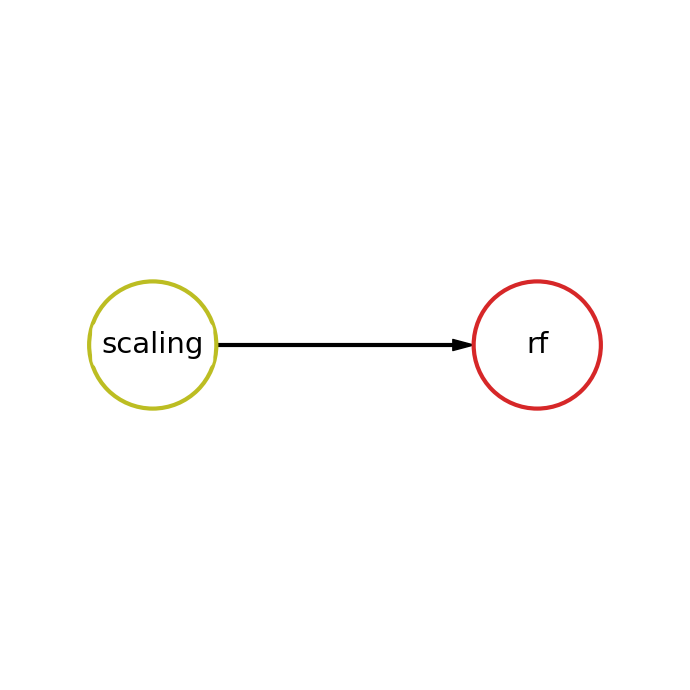

Pipeline structure:
{'depth': 2, 'length': 2, 'nodes': [rf, scaling]}
rf - {'n_jobs': 12}
scaling - {}


In [28]:
best_pipeline.show()
best_pipeline.print_structure()

In [30]:
prediction = model.predict_proba(features=dataset.test_split.data)
auto_metrics = model.get_metrics()
print(auto_metrics)

Exception: Invalid fitness after objective evaluation. Skipping the graph: (/n_scaling;)/n_rf_{'n_jobs': 12}

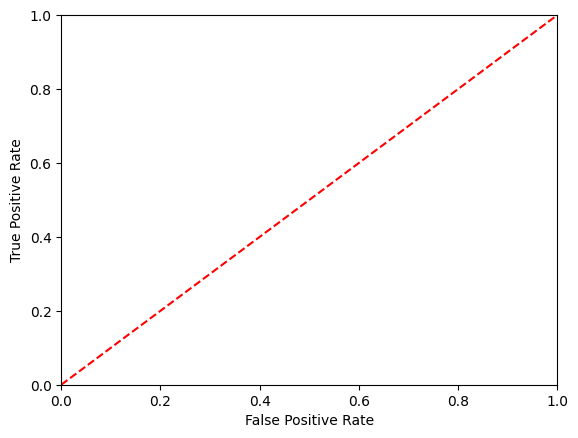

In [20]:
model.plot_prediction()